# Purdue CS176 Fall 2024 Project — Team 3

### Contributors
Frederick Lu (lu1137@purdue.edu), Kevin Huang (huan2151@purdue.edu), Yonghyun Kang (kang612@purdue.edu)

### Contribution Guidelines

Please follow [PEP-8](https://peps.python.org/pep-0008/) guidelines as much as possible.

## Prerequisitives & Configurations

In [3]:
%env SOURCE=datasets
%env OUTPUT=outputs

# FOR DEV
# %env ENV=DEV

# FOR GENERATING PRODUCTION FIGURES
%env ENV=PROD

env: SOURCE=datasets
env: OUTPUT=outputs
env: ENV=PROD


In [4]:
from ast import literal_eval
from itertools import combinations
import os

import matplotlib.pyplot as plt
from matplotlib.axes import Axes
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, TruncatedSVD

In [5]:
DIR_DS = os.environ['SOURCE']
DIR_FG = f'{os.environ['OUTPUT']}/figures'

In [6]:
# https://www.kaggle.com/datasets/dhruvildave/spotify-charts
chart_df = pd.read_csv(f'{DIR_DS}/charts.csv')
# chart_df.head()

# https://www.kaggle.com/datasets/irynatokarchuk/top-streamed-spotify-songs-by-year-2010-2023
stream_df = pd.read_csv(f'{DIR_DS}/top_stream.csv').iloc[:, 1:]
# stream_df.head()

# https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
meta_df = pd.read_csv(f'{DIR_DS}/meta.csv').iloc[:, 1:]
# meta_df.head()

# https://www.kaggle.com/datasets/nelgiriyewithana/most-streamed-spotify-songs-2024
pop_df = pd.read_csv(f'{DIR_DS}/general_popularity.csv', thousands=',', encoding='unicode_escape')  # manually assign encoding method in order to avoid utf8 conversion error
# pop_df.head()

In [130]:
is_prod = os.environ['ENV'] == 'PROD'

if os.environ['ENV'] == 'PROD':
    import scienceplots

    plt.style.use('ieee')
    # plt.style.use(['science', 'ieee'])

    plt.rcParams['text.usetex'] = False
    plt.rcParams['font.family'] = 'sans-serif'

else:
    plt.rcParams.update(plt.rcParamsDefault)

def annotate(c, title: str = None, xlabel: str = None, ylabel: str = None):
    if not plt and not ax:
        pass

    elif title and not is_prod:
        if isinstance(c, Axes):
            c.set_title(title)
            c.set_xlabel(xlabel)
            c.set_ylabel(ylabel)
        else:
            c.title(title)
            c.xlabel(xlabel)
            c.ylabel(ylabel)

## Preprocessing

In [8]:
# preprocess stream_df
stream_df[['Artist', 'Title']] = stream_df['Artist and Title'].str.extract('^(.*?)\\s-\\s(.*)')
if type(stream_df['genres'][0]) is not list:
    stream_df['genres'] = stream_df['genres'].dropna().apply(literal_eval)

display(stream_df)

# master_df = pd.merge(meta_df, stream_df, how='outer', left_on=['artists', 'track_name'], right_on=['Artist', 'Title'])
# master_df = pd.merge(master_df, pop_df, how='outer', left_on=['artists', 'track_name'], right_on=['Artist', 'Track'])

just_impeccable_df = pd.merge(meta_df, stream_df, how='inner', left_on=['artists', 'track_name'], right_on=['Artist', 'Title'])
just_impeccable_df = pd.merge(just_impeccable_df, pop_df, how='inner', left_on=['artists', 'track_name'], right_on=['Artist', 'Track'])

# display(just_impeccable_df.columns)
just_impeccable_df.drop_duplicates(subset=['track_name', 'artists'], inplace=True)  # eliminate redundant tracks in different albums

tdf = just_impeccable_df[['track_id', 'artists', 'track_name', 'first_genre', 'Spotify Streams', 'YouTube Views', 'TikTok Views']]

sptf_df = tdf.sort_values('Spotify Streams').dropna()
yt_df = tdf.sort_values('YouTube Views').dropna()
tt_df = tdf.sort_values('TikTok Views').dropna()

display(sptf_df)

,Artist and Title,Artist,Streams,Daily,year,main_genre,genres,first_genre,second_genre,third_genre,Title
0,J. Cole - No Role Modelz,J. Cole,2300753974,987553,2014.0,Hip-Hop/Rap,"[conscious hip hop, hip hop, north carolina hi...",conscious hip hop,hip hop,north carolina hip hop,No Role Modelz
1,Sam Smith - Stay With Me,Sam Smith,2135129240,875392,2014.0,Pop,"[pop, uk pop]",pop,uk pop,Unknown,Stay With Me
2,Mark Ronson - Uptown Funk,Mark Ronson,2039781091,675268,2014.0,Pop,[pop soul],pop soul,Unknown,Unknown,Uptown Funk
3,Sam Smith - I'm Not The Only One,Sam Smith,1926711475,791299,2014.0,Pop,"[pop, uk pop]",pop,uk pop,Unknown,I'm Not The Only One
4,Maroon 5 - Sugar,Maroon 5,1877824112,552959,2014.0,Pop,[pop],pop,Unknown,Unknown,Sugar
...,...,...,...,...,...,...,...,...,...,...,...
10436,iann dior - molly,iann dior,138112487,21049,2019.0,Hip-Hop/Rap,[melodic rap],melodic rap,Unknown,Unknown,molly
10437,Roddy Ricch - Tip Toe,Roddy Ricch,137996968,10699,2019.0,Hip-Hop/Rap,"[melodic rap, rap, trap]",melodic rap,rap,trap,Tip Toe
10438,Sigrid - Strangers,Sigrid,137925577,15840,2019.0,Pop,"[electropop, norwegian pop]",electropop,norwegian pop,Unknown,Strangers
10439,GAMPER & DADONI - Gimme! Gimme! Gimme!,GAMPER & DADONI,137471196,60612,2019.0,Electronic/Dance,"[german dance, pop dance, tropical house]",german dance,pop dance,tropical house,Gimme! Gimme! Gimme!


,track_id,artists,track_name,first_genre,Spotify Streams,YouTube Views,TikTok Views
575,6zVYlwTqj7D7bRAfalOZg0,Ava Max,Million Dollar Baby,pop,1.062189e+08,5.437172e+07,4.494030e+07
1446,61tqrU7wp1EnoJ5ajtYXMl,BLACKPINK,Ready For Love,k-pop,1.152376e+08,2.435095e+08,5.152656e+07
1471,2WTHLEVjfefbGoW7F3dXIg,aespa,Girls,k-pop girl group,1.154069e+08,2.673484e+08,4.012608e+08
264,7g0Zfd5J6Hzx9M2fRUMuba,Parmalee,Take My Name,contemporary country,1.209647e+08,1.391993e+07,4.354620e+07
50,5xUhs6dlfkcxZM8zq7riYF,Red Hot Chili Peppers,Black Summer,alternative rock,1.282641e+08,5.725274e+07,2.059053e+07
...,...,...,...,...,...,...,...
1953,0pqnGHJpmpxLKifKRmU6WP,Imagine Dragons,Believer,modern rock,3.006227e+09,4.495060e+09,5.876459e+09
1778,4LRPiXqCikLlN15c3yImP7,Harry Styles,As It Was,pop,3.301815e+09,8.008993e+08,1.540588e+10
1826,7qEHsqek33rTcFNT9PFqLf,Lewis Capaldi,Someone You Loved,pop,3.427499e+09,2.153702e+09,2.161032e+09
1742,7qiZfU4dY1lWllzX7mPBI3,Ed Sheeran,Shape of You,pop,3.909459e+09,8.013997e+09,2.320856e+09


## Visualizations

### Annual Stats

,Streams,track_count
year,,
2010,43139743417,133
2011,83844848018,156
2012,118213517600,193
2013,182251839379,293
2014,167256743423,290
2015,206969466584,365
2016,151003388947,344
2017,231542795426,351
2018,267182510174,470


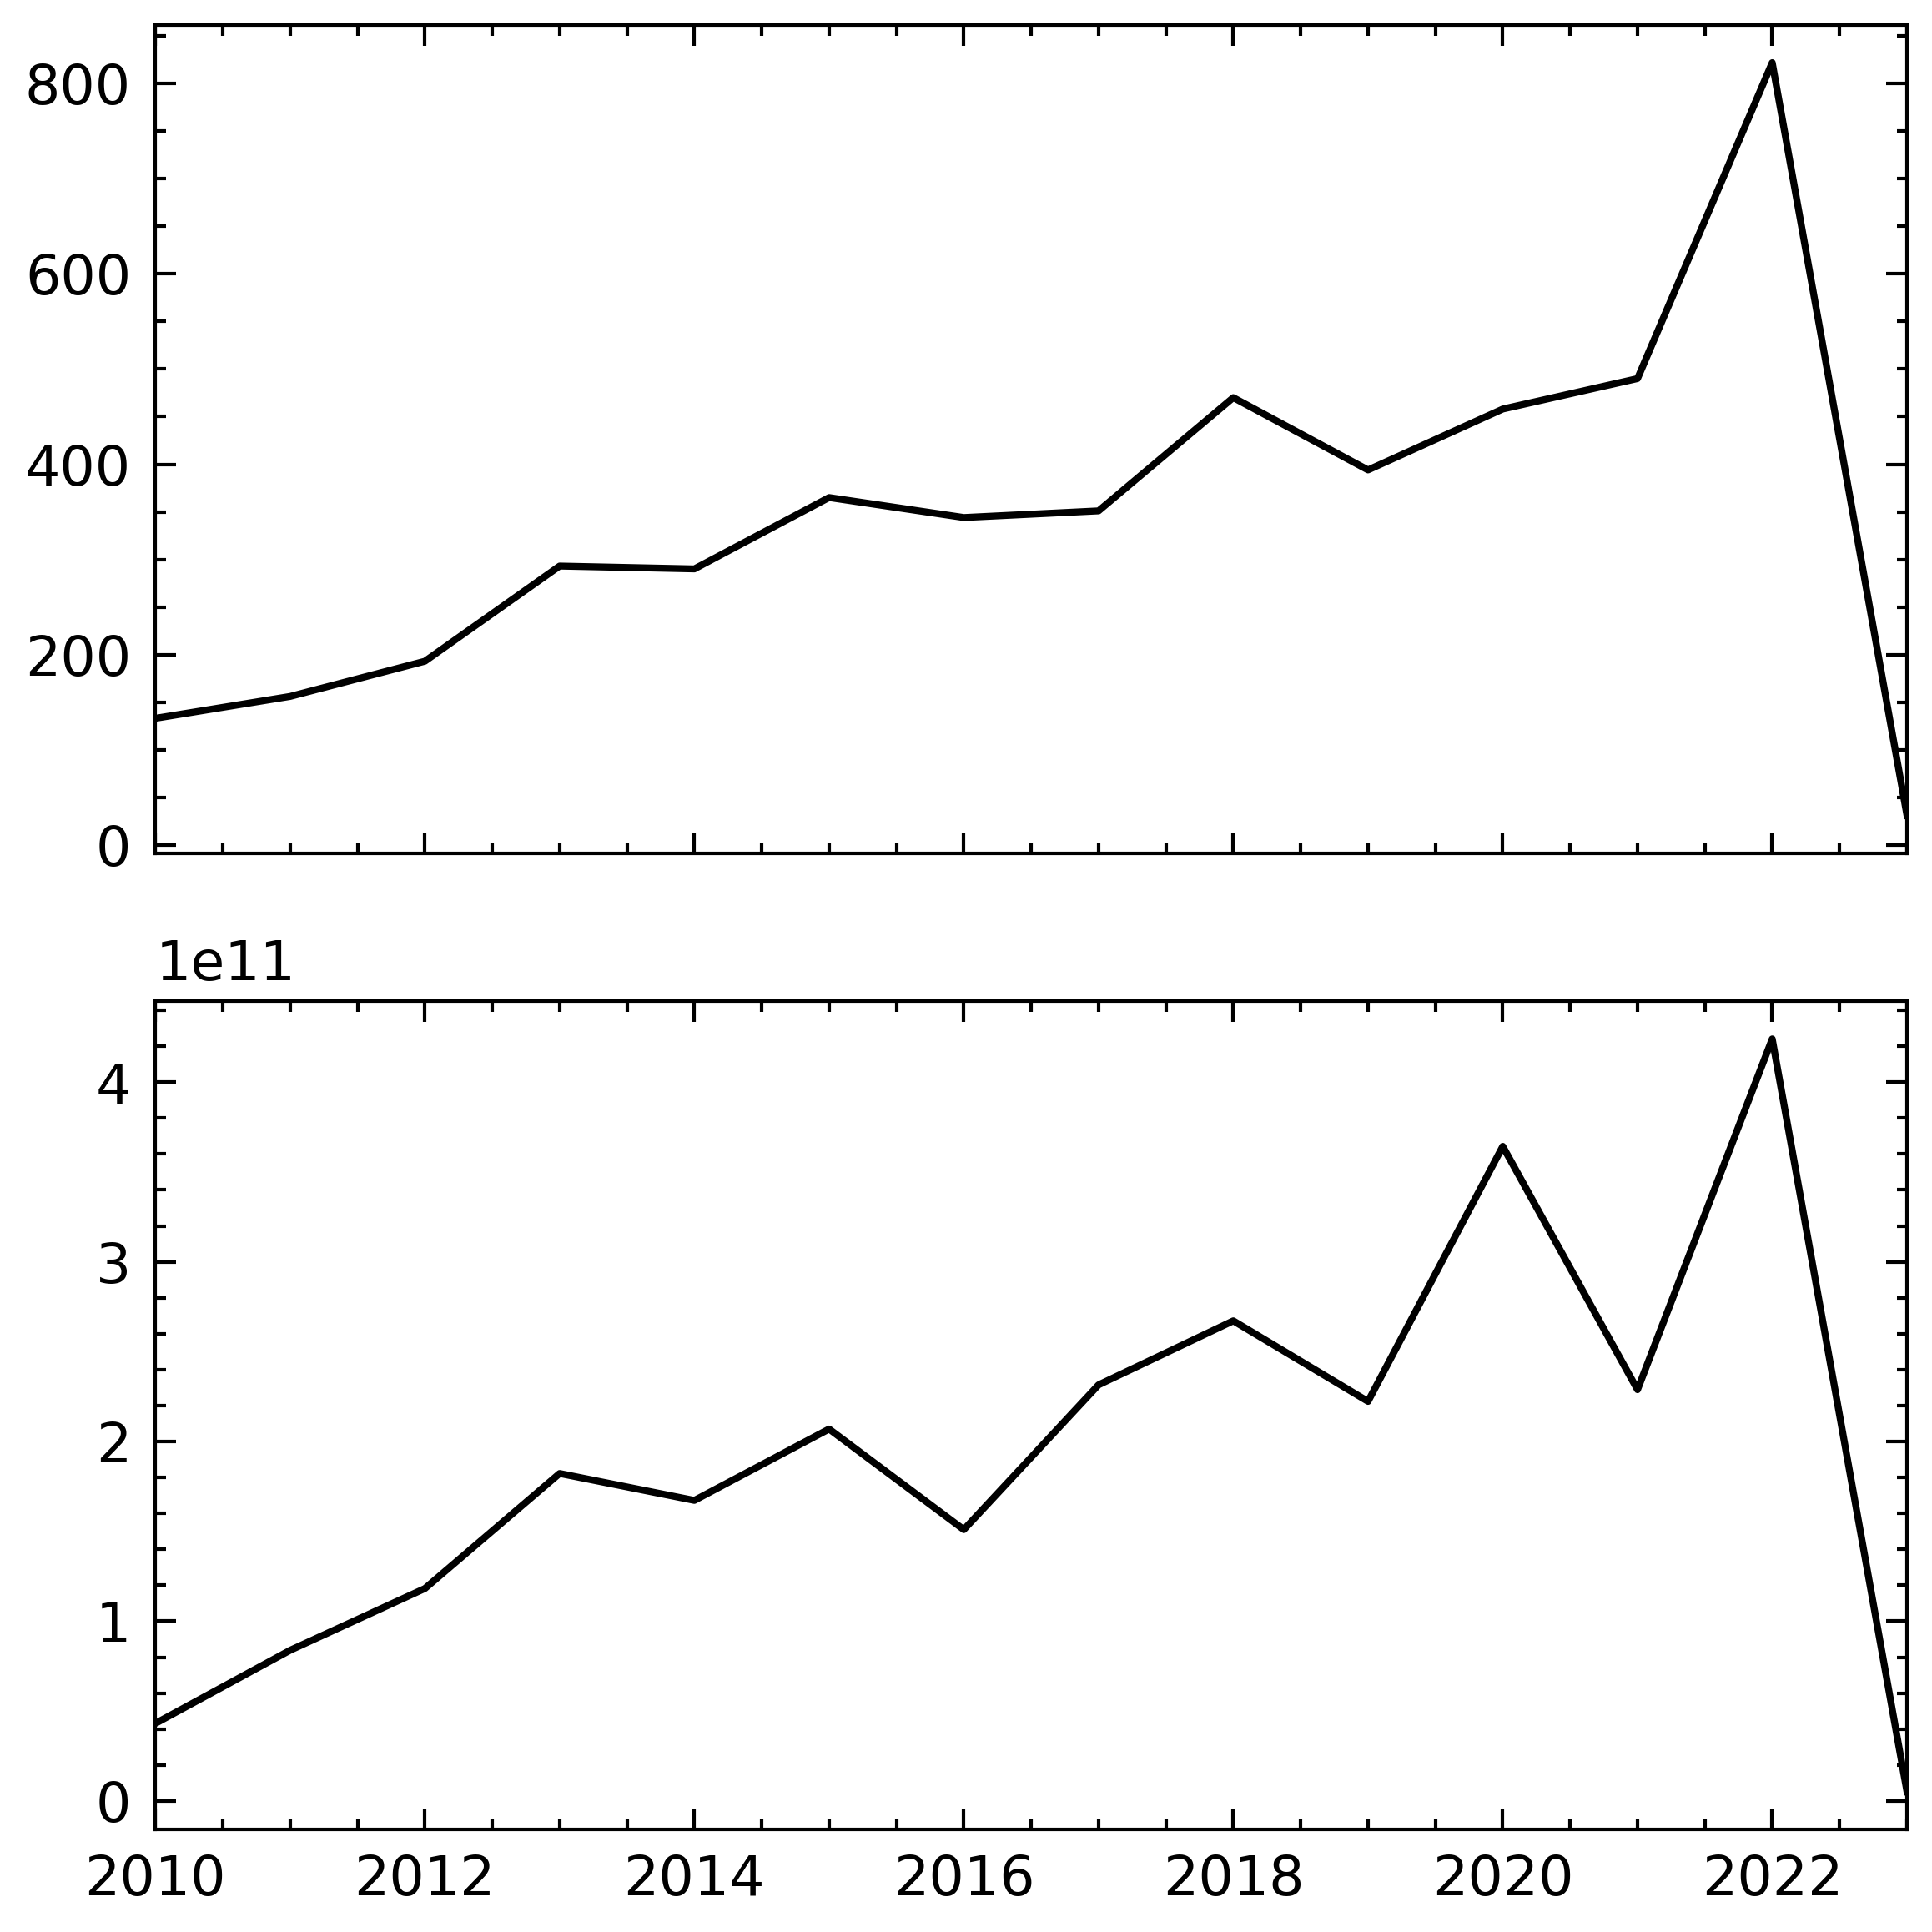

<Figure size 1980x1500 with 0 Axes>

In [9]:
meta_stream_df = pd.merge(meta_df, stream_df, how='inner', left_on=['artists', 'track_name'], right_on=['Artist', 'Title'])
meta_stream_df.sort_values('Streams', ascending=False, inplace=True)
meta_stream_df['year'] = meta_stream_df['year'].astype(int)

# display(meta_stream_df[meta_stream_df['year'] == 2023])

df = meta_stream_df.pivot_table(index='year', values='Streams', aggfunc='sum')
df['track_count'] = meta_stream_df.pivot_table(index='year', values='track_id', aggfunc='count').values

display(df)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(4, 2 * 2))

ax[0].plot(df.index, df['track_count'])
ax[1].plot(df.index, df['Streams'])

for a in ax:
  plt.xlim(2010, 2023)
  # plt.xticks(rotation=90)

annotate(ax[0], title='Number of total streaming over years', xlabel='Year', ylabel='Number of streams')

plt.tight_layout()
plt.show()

plt.savefig(f'{DIR_FG}/annual_total_streaming.svg', format='svg')

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,Artist,Streams,Daily,year,main_genre,genres,first_genre,second_genre,third_genre,Title
4146,0VjIjW4GlUZAMYd2vXMi3b,The Weeknd,After Hours,Blinding Lights,91,200040,False,0.514,0.730,1,...,The Weeknd,4387731728,1640271,2020,R&B/Soul,canadian contemporary r&b,canadian contemporary r&b,canadian pop,pop,Blinding Lights
4146,0VjIjW4GlUZAMYd2vXMi3b,The Weeknd,After Hours,Blinding Lights,91,200040,False,0.514,0.730,1,...,The Weeknd,4387731728,1640271,2020,R&B/Soul,canadian pop,canadian contemporary r&b,canadian pop,pop,Blinding Lights
4146,0VjIjW4GlUZAMYd2vXMi3b,The Weeknd,After Hours,Blinding Lights,91,200040,False,0.514,0.730,1,...,The Weeknd,4387731728,1640271,2020,R&B/Soul,pop,canadian contemporary r&b,canadian pop,pop,Blinding Lights
4147,7LltNXuqCBGOAp1iwmAmB3,The Weeknd,Halloween 2022,Blinding Lights,0,201573,False,0.512,0.796,1,...,The Weeknd,4387731728,1640271,2020,R&B/Soul,canadian contemporary r&b,canadian contemporary r&b,canadian pop,pop,Blinding Lights
4147,7LltNXuqCBGOAp1iwmAmB3,The Weeknd,Halloween 2022,Blinding Lights,0,201573,False,0.512,0.796,1,...,The Weeknd,4387731728,1640271,2020,R&B/Soul,canadian pop,canadian contemporary r&b,canadian pop,pop,Blinding Lights
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1234,3iLBFgaQJ94iarMgzrTuWb,Charlie Puth,CHARLIE,I Don’t Think That I Like Her,65,188507,False,0.587,0.548,8,...,Charlie Puth,100992346,60845,2022,Pop,pop,pop,viral pop,Unknown,I Don’t Think That I Like Her
1234,3iLBFgaQJ94iarMgzrTuWb,Charlie Puth,CHARLIE,I Don’t Think That I Like Her,65,188507,False,0.587,0.548,8,...,Charlie Puth,100992346,60845,2022,Pop,viral pop,pop,viral pop,Unknown,I Don’t Think That I Like Her
1233,0Ts1lnK3lYa2dwE2orDJc5,Charlie Puth,CHARLIE,I Don’t Think That I Like Her,66,188507,False,0.587,0.548,8,...,Charlie Puth,100992346,60845,2022,Pop,pop,pop,viral pop,Unknown,I Don’t Think That I Like Her
1233,0Ts1lnK3lYa2dwE2orDJc5,Charlie Puth,CHARLIE,I Don’t Think That I Like Her,66,188507,False,0.587,0.548,8,...,Charlie Puth,100992346,60845,2022,Pop,viral pop,pop,viral pop,Unknown,I Don’t Think That I Like Her


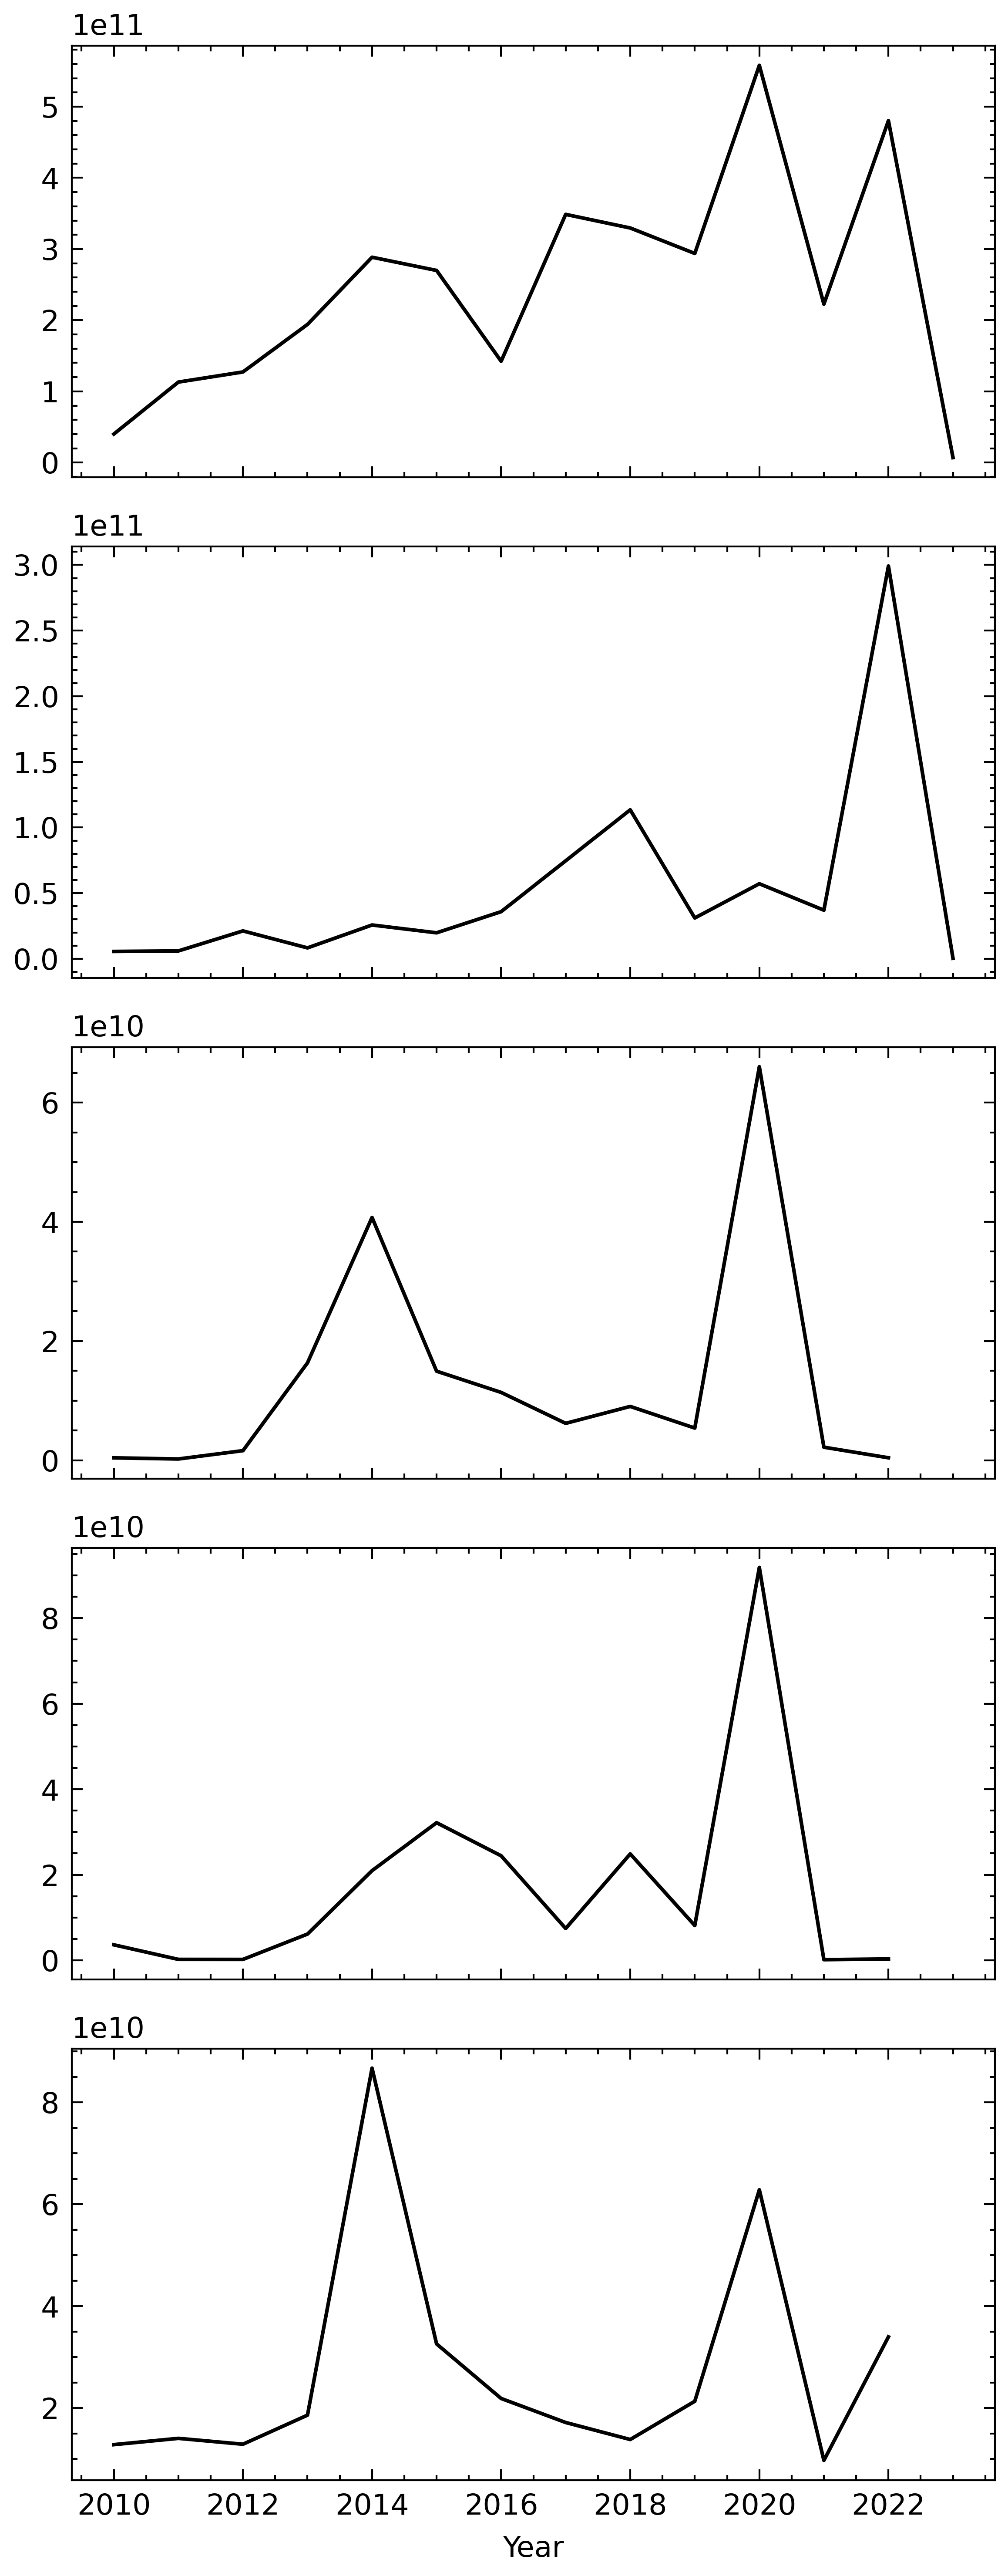

In [10]:
genres_df = meta_stream_df.explode('genres').dropna()

display(genres_df)

def get_df_by_genre(g, v='Streams'):
    x = genres_df[genres_df['genres'].str.contains(g)]
    return x.pivot_table(index='year', values=v, aggfunc='sum')

# display(get_df_by_genre('pop'))

vgenres = ['pop', 'rap', 'edm', 'house', 'dance']

fig, ax = plt.subplots(nrows=len(vgenres), sharex=True, figsize=(4,2 * len(vgenres)))

for idx, g in enumerate(vgenres):
    ax[idx].plot(get_df_by_genre(g).index, get_df_by_genre(g).values)

    annotate(ax[idx], title=f'Number of {g} streaming over years', ylabel='Number of streams')

plt.xlabel("Year")

plt.tight_layout()
plt.show()

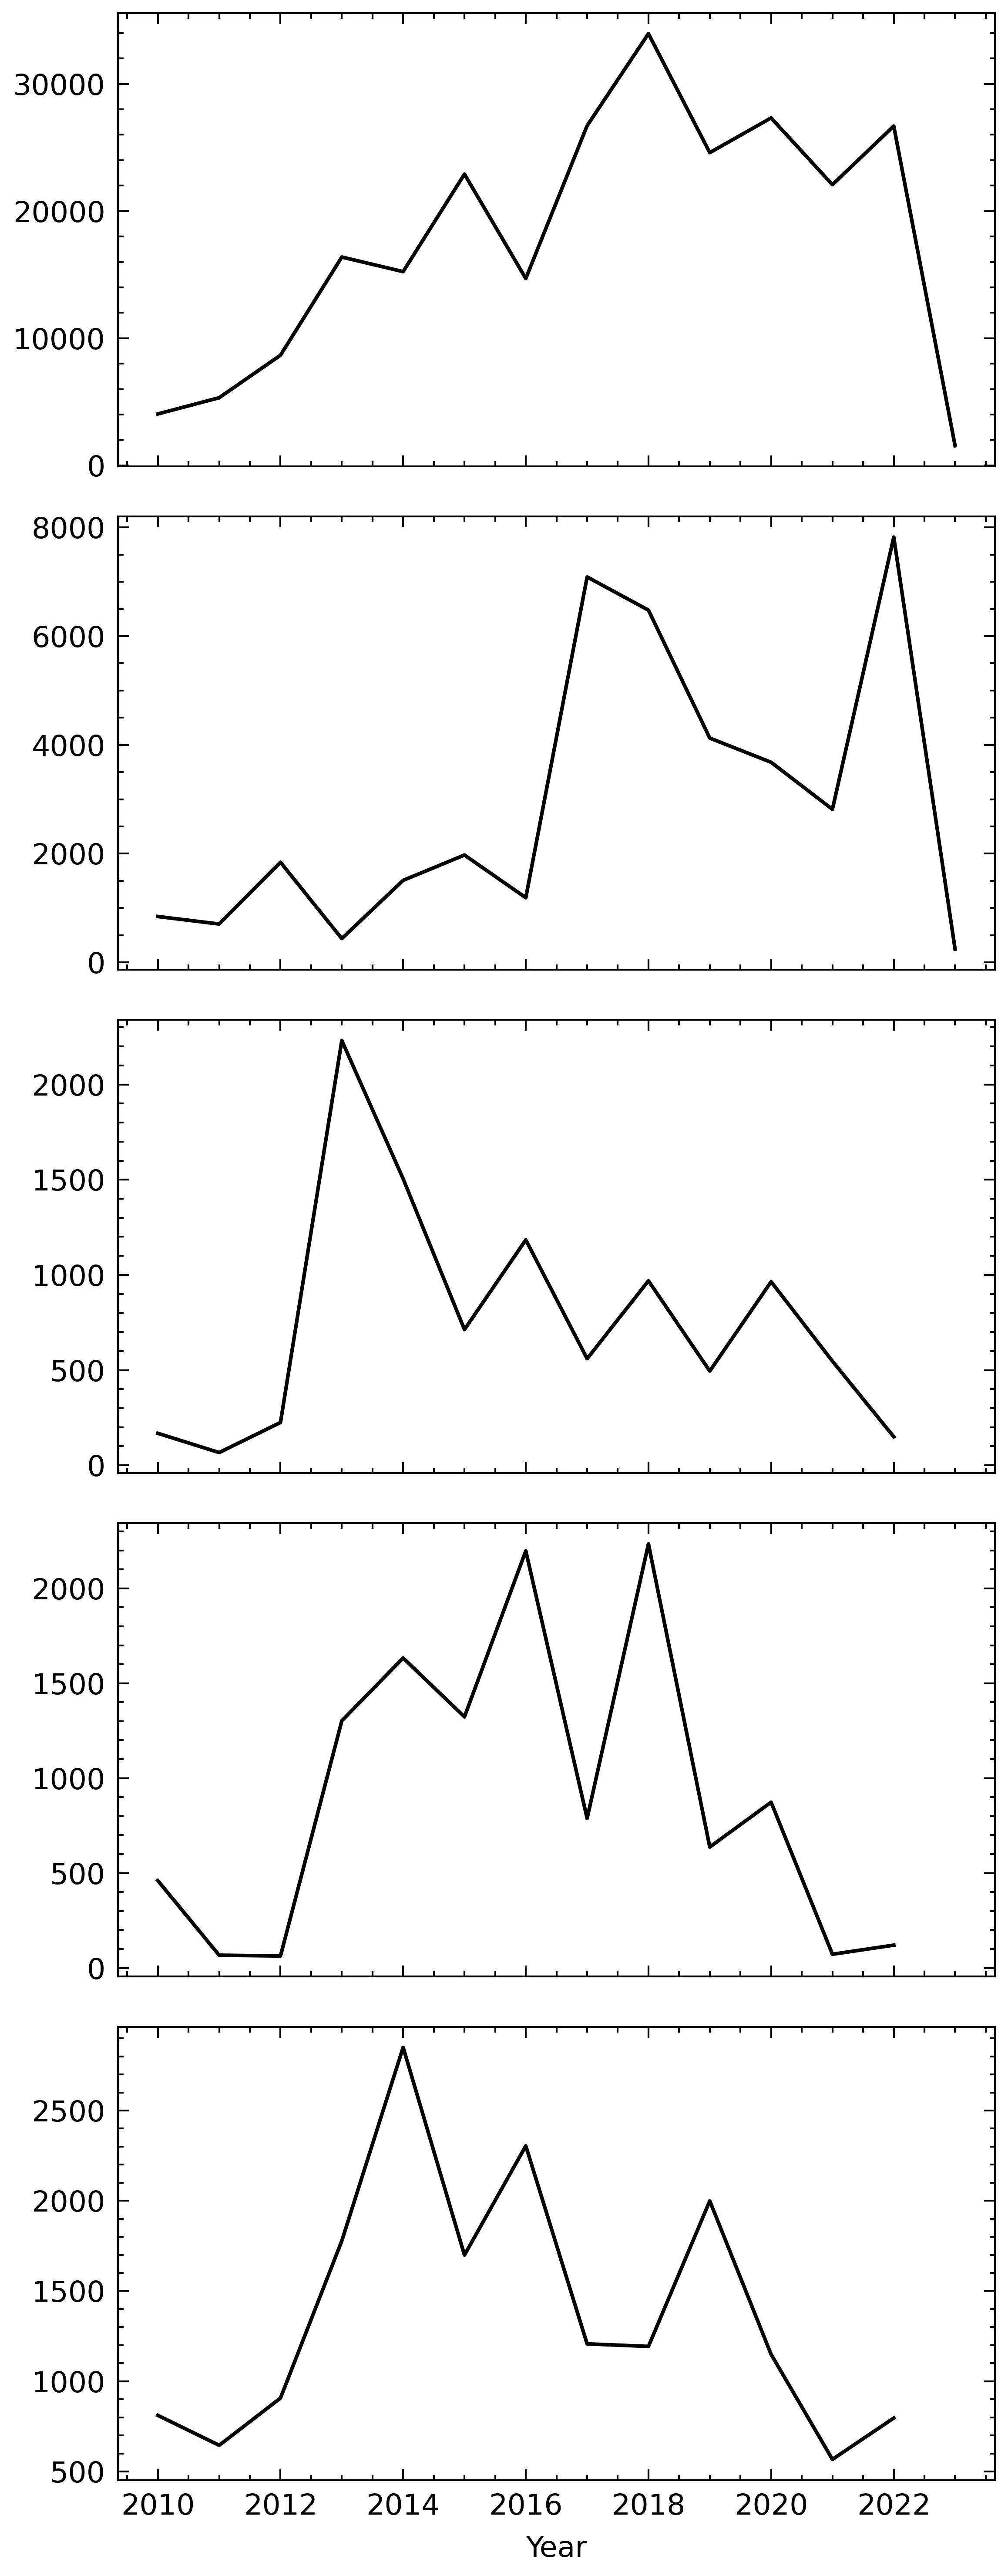

In [11]:
fig, ax = plt.subplots(nrows=len(vgenres), sharex=True, figsize=(4, 2 * len(vgenres)))

for idx, g in enumerate(vgenres):
    ax[idx].plot(get_df_by_genre(g, v='popularity').index, get_df_by_genre(g, v='popularity').values)

    annotate(ax[idx], title=f'Popularity of {g} over years', ylabel='Popularity')

plt.xlabel('Year')

plt.tight_layout()
plt.show()

,Streams,popularity
genres,,
acoustic opm,1491189785,521
acoustic pop,6523992915,1007
adult standards,10666133472,1074
aesthetic rap,994724532,351
afrobeats,34667985185,854
...,...,...
west coast rap,2747264200,167
world worship,13355800460,311
worship,13355800460,311


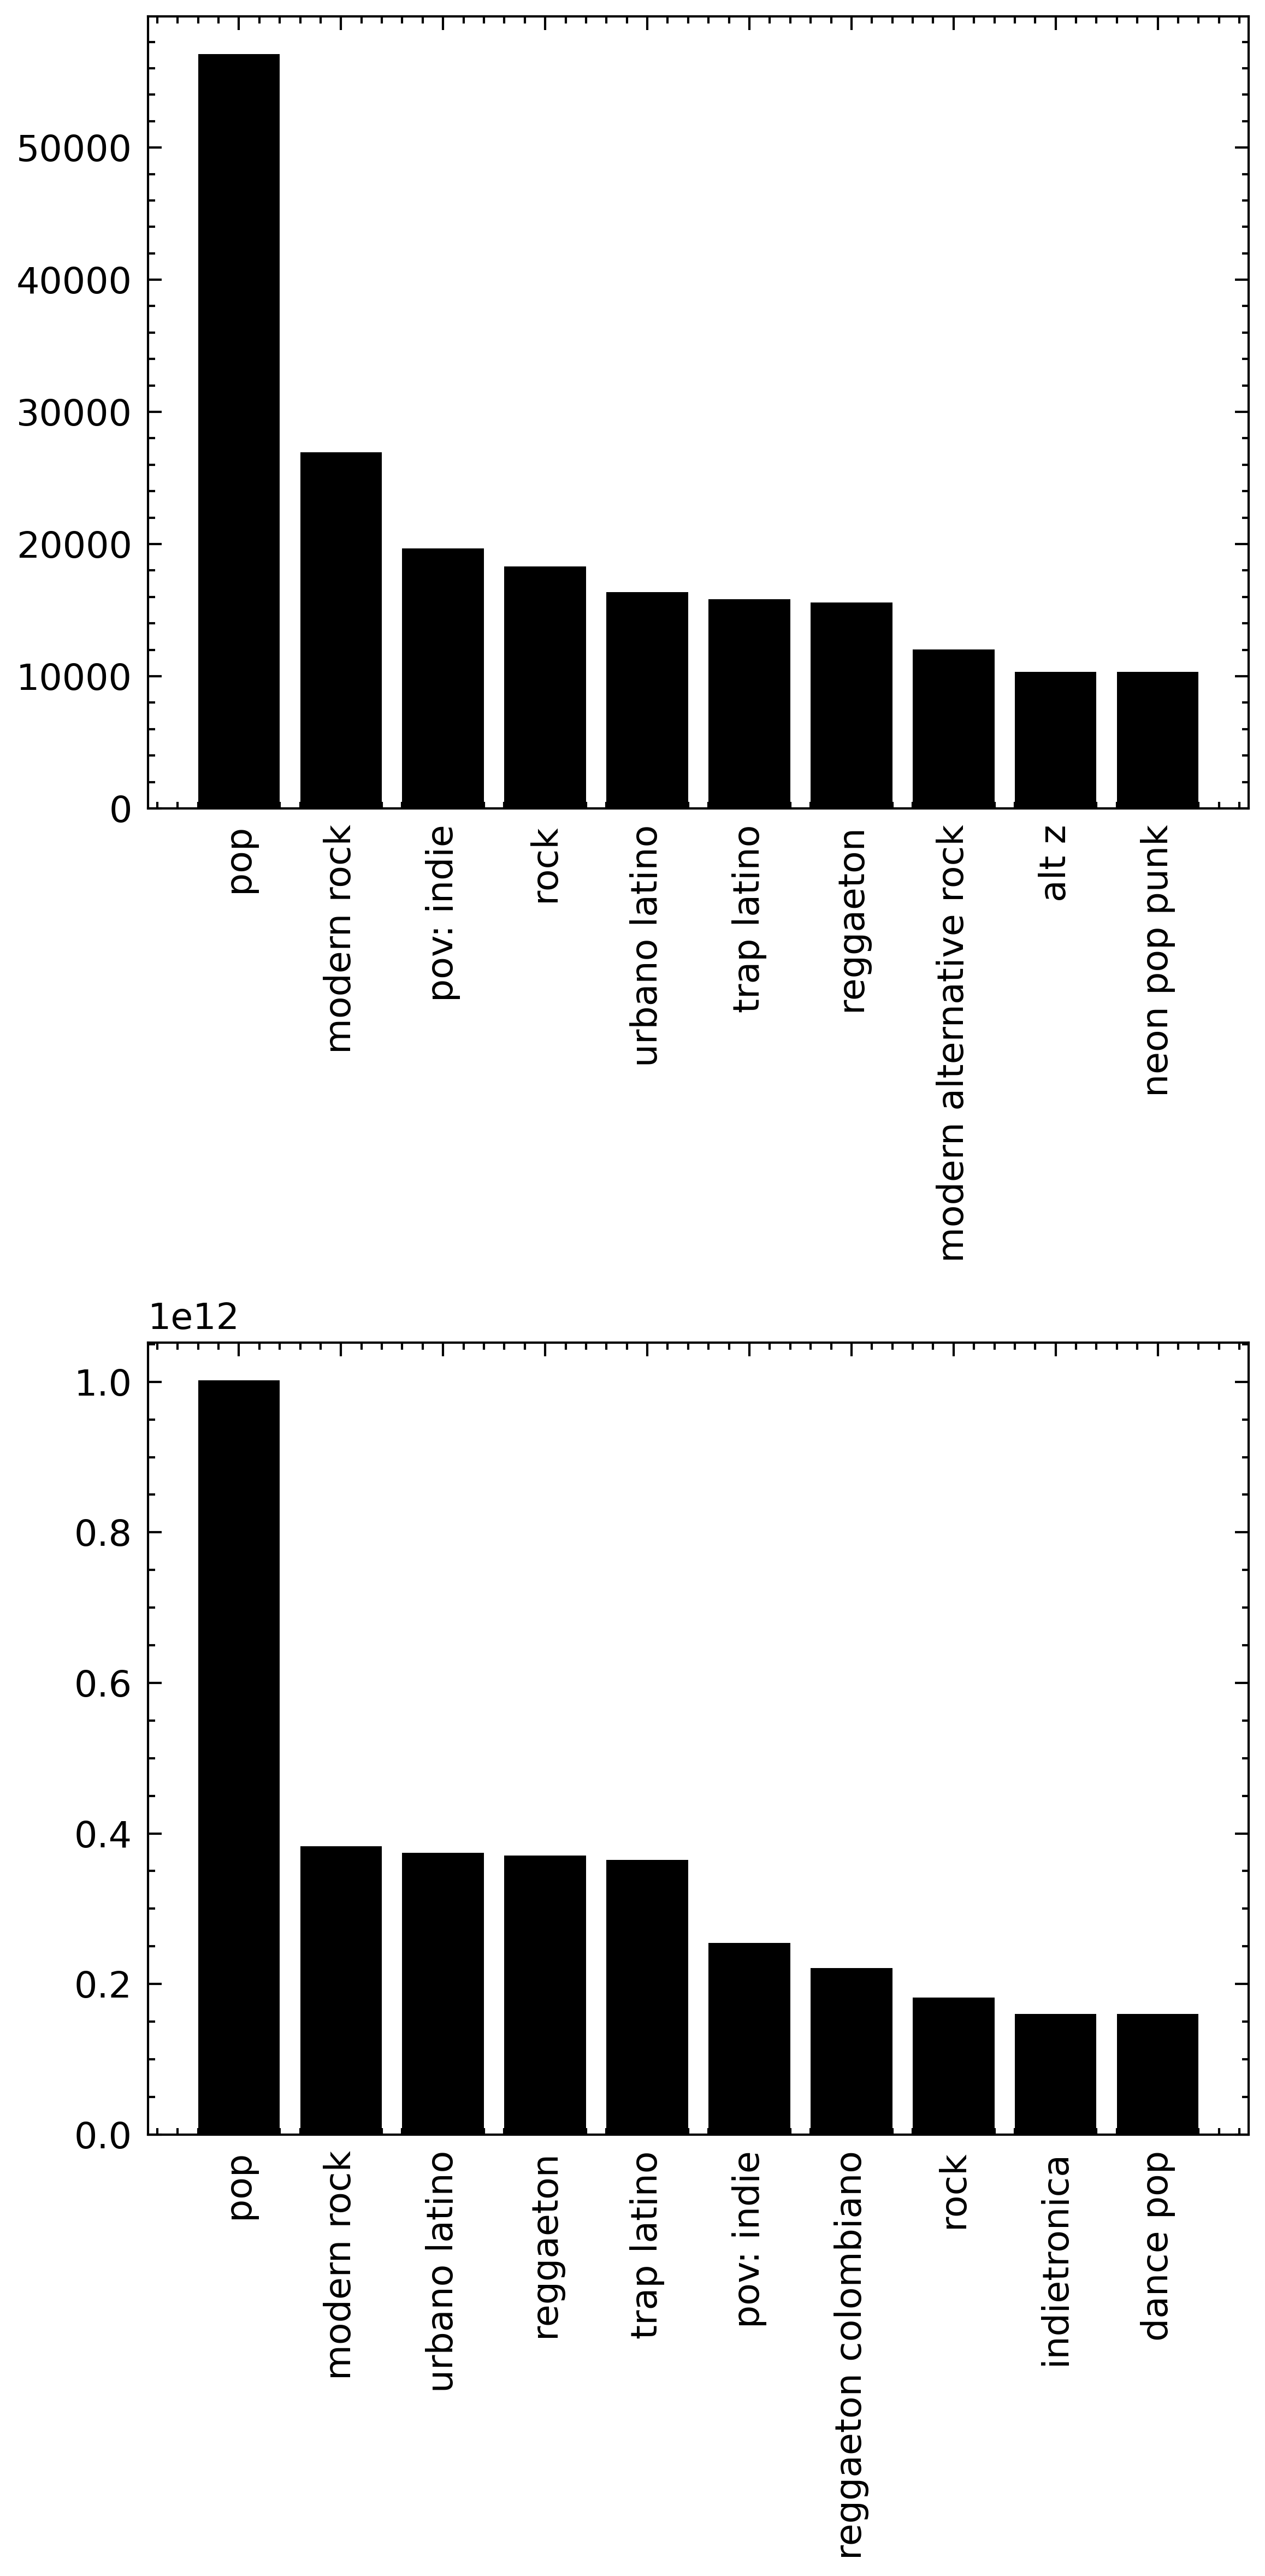

In [12]:
df = genres_df.pivot_table(index='genres', values=['Streams', 'popularity'], aggfunc='sum')

df1 = df.sort_values('popularity', ascending=False)
df1 = df1['popularity'].head(10)

df2 = df.sort_values('Streams', ascending=False)
df2 = df2['Streams'].head(10)

display(df)

fig, ax = plt.subplots(nrows=2, figsize=(4, 8))

ax[0].bar(df1.index, df1.values)
ax[1].bar(df2.index, df2.values)

for a in ax:
    plt.sca(a)
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

### Genre Analysis

,conscious hip hop,hip hop,north carolina hip hop,rap,pop,uk pop,pop soul,dance pop,edm,pop dance,...,turkish edm,latinx alternative,modern reggae,chinese idol pop,brega funk,scandinavian r&b,tontipop,progressive metal,vancouver metal,malang indie
conscious hip hop,131,126,41,125,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hip hop,126,839,53,821,0,0,0,12,0,0,...,0,0,0,0,0,0,0,0,0,0
north carolina hip hop,41,53,55,53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
rap,125,821,53,1572,133,0,0,20,0,0,...,0,0,0,0,0,0,0,0,0,0
pop,0,0,0,133,2481,231,5,482,196,161,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scandinavian r&b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
tontipop,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
progressive metal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
vancouver metal,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0


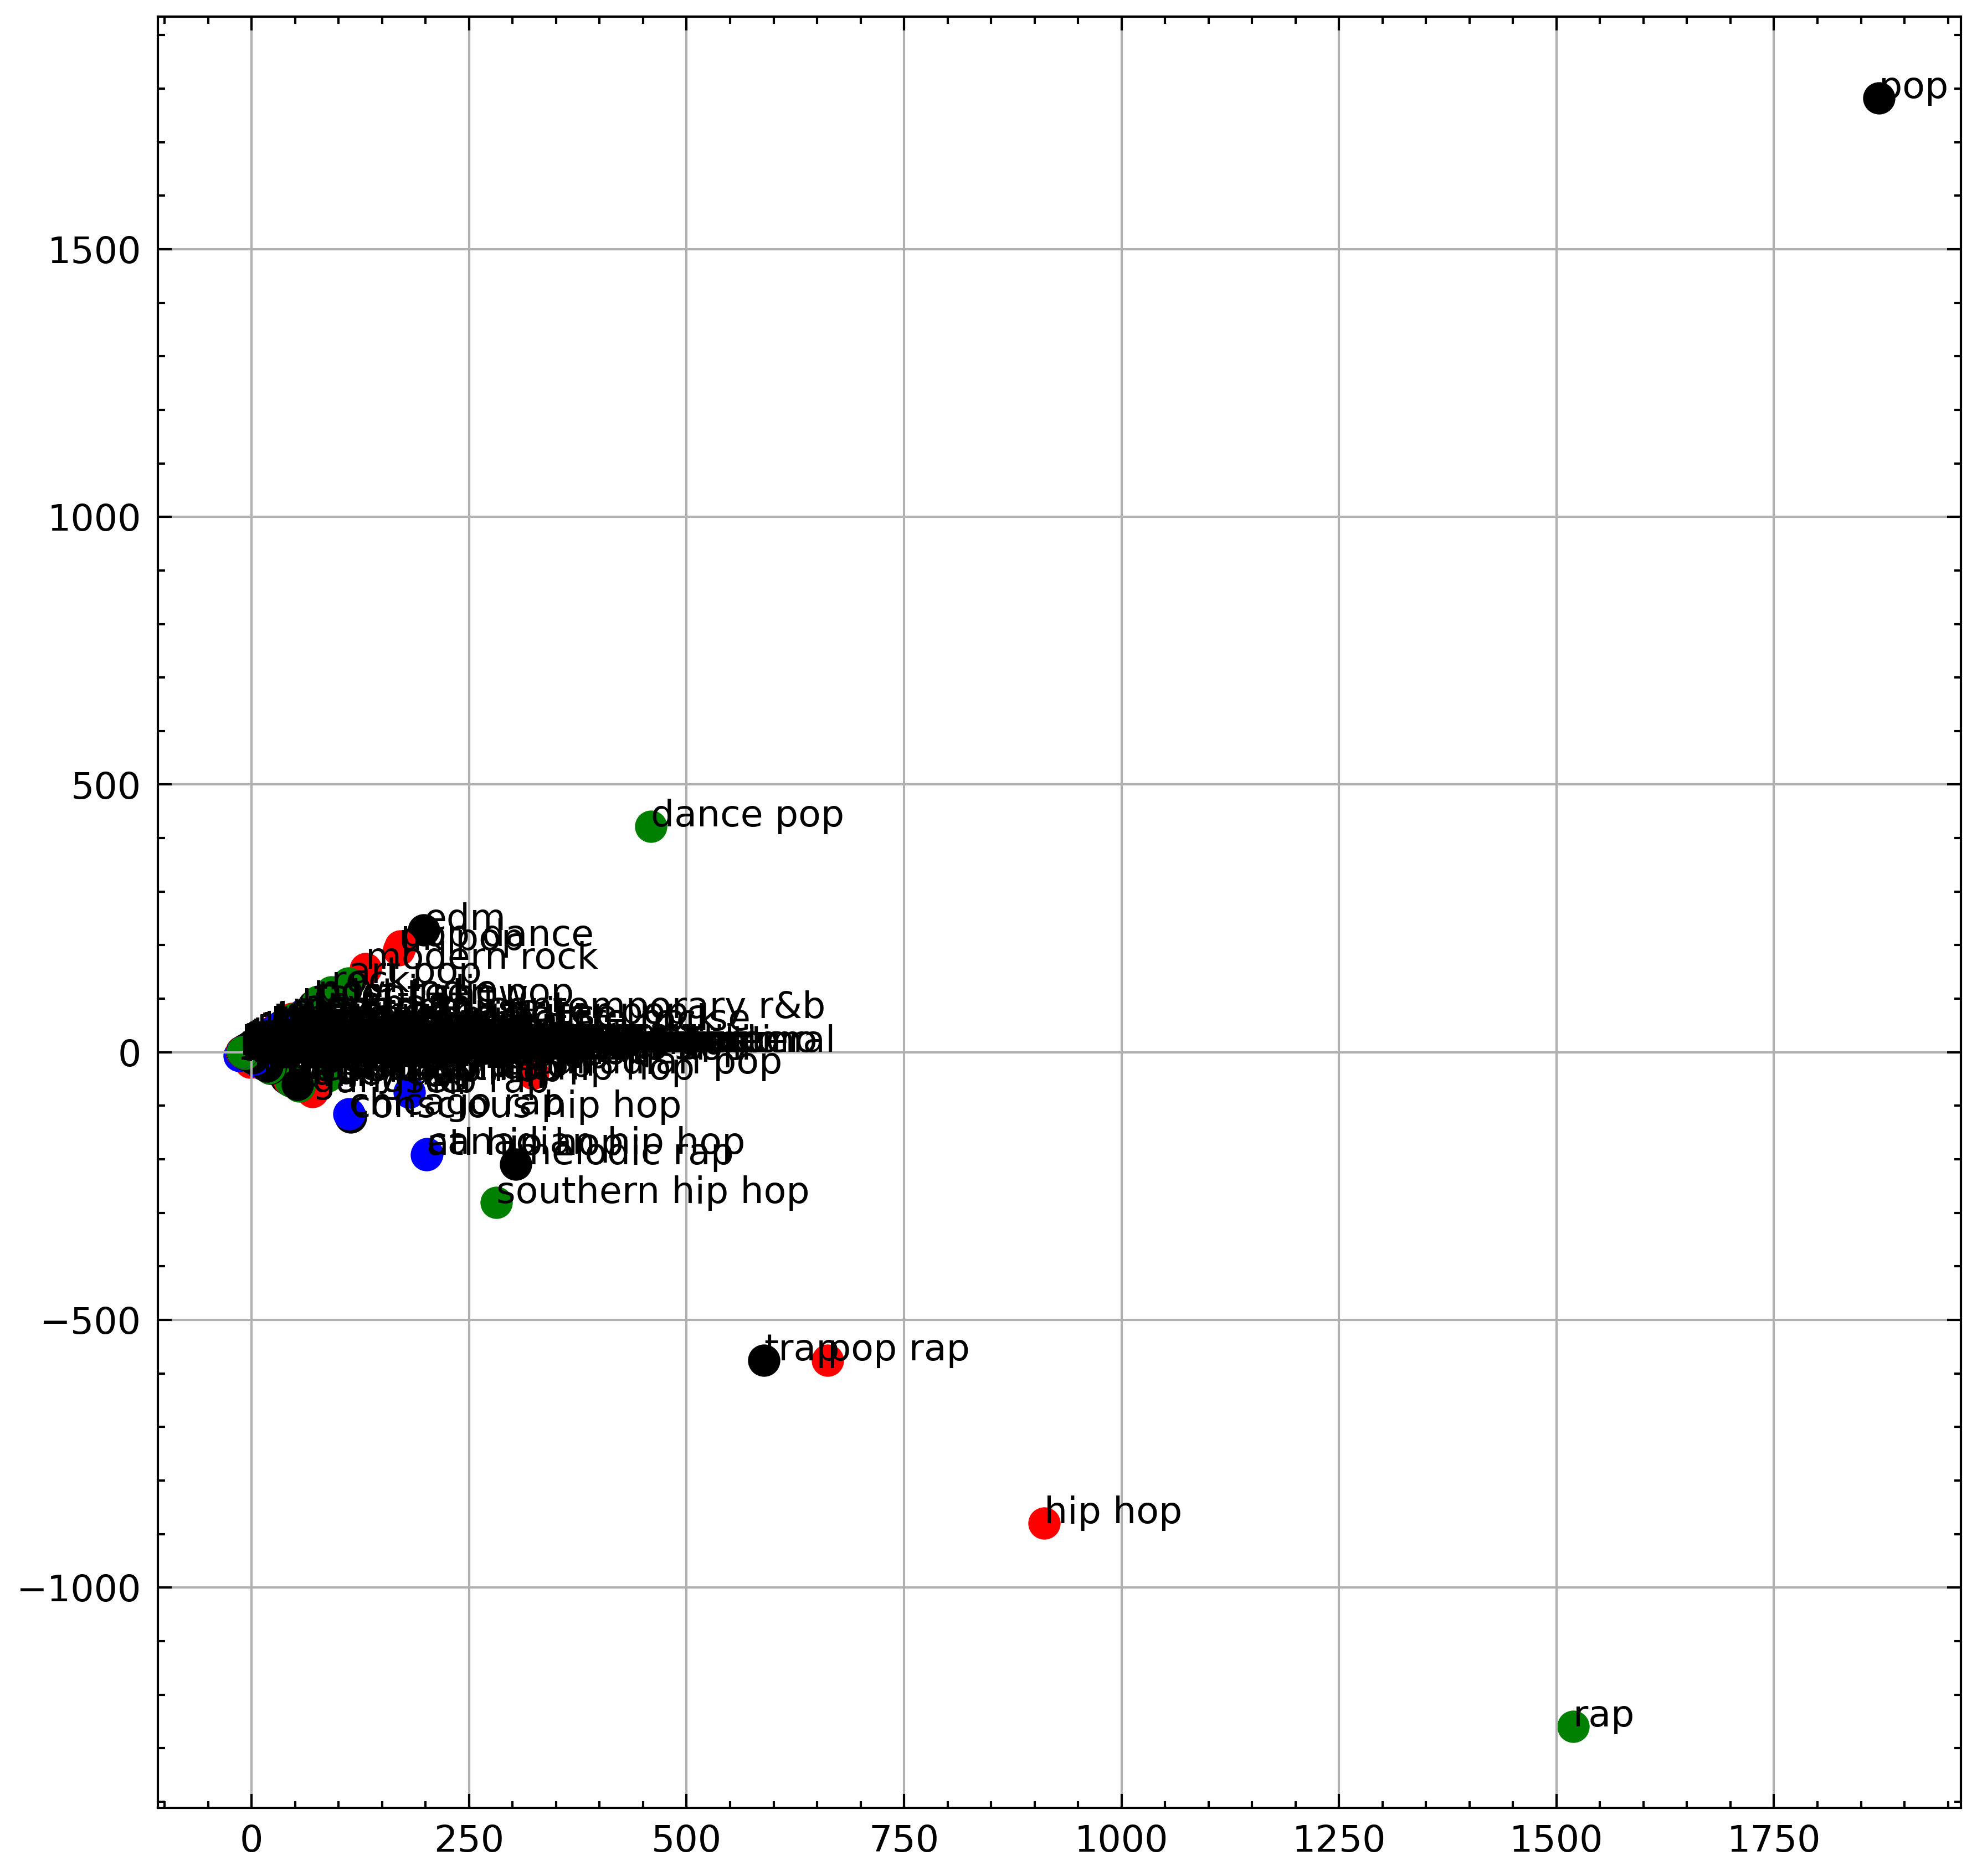

In [45]:
df = stream_df['genres'].dropna()

unique_genres = list(df.explode().dropna().unique())

genres_co_occu = pd.DataFrame(0, index=unique_genres, columns=unique_genres)

for index in df.index:
  gs = df[index]

  for g1, g2 in combinations(gs, 2):
    genres_co_occu.loc[g1, g2] += 1
    genres_co_occu.loc[g2, g1] += 1

  for g in gs:
    genres_co_occu.loc[g, g] += 1

display(genres_co_occu)

pca = PCA(n_components=2)
pca_reduced_data = pca.fit_transform(genres_co_occu)

# svd = TruncatedSVD(n_components=2)
# svd_reduced_data = svd.fit_transform(genres_co_occu)

fig, ax = plt.subplots(figsize=(7, 7))

for i, genre in enumerate(unique_genres):
  ax.scatter(pca_reduced_data[i, 0], pca_reduced_data[i, 1], label=genre)
  ax.text(pca_reduced_data[i, 0] + 0.02, pca_reduced_data[i, 1] + 0.02, genre)

plt.grid(True)

# fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
#
# plt.figure(figsize=(10, 8))
# for i, genre in enumerate(genres):
#     ax[0].scatter(pca_reduced_data[i, 0], pca_reduced_data[i, 1], label=genre)
#     ax[0].text(pca_reduced_data[i, 0] + 0.02, pca_reduced_data[i, 1] + 0.02, genre)
#     ax[1].scatter(svd_reduced_data[i, 0], svd_reduced_data[i, 1], label=genre)
#     ax[1].text(svd_reduced_data[i, 0] + 0.02, svd_reduced_data[i, 1] + 0.02, genre)
#
# for a in ax:
#     a.grid(True)
#
# plt.tight_layout()
plt.show()

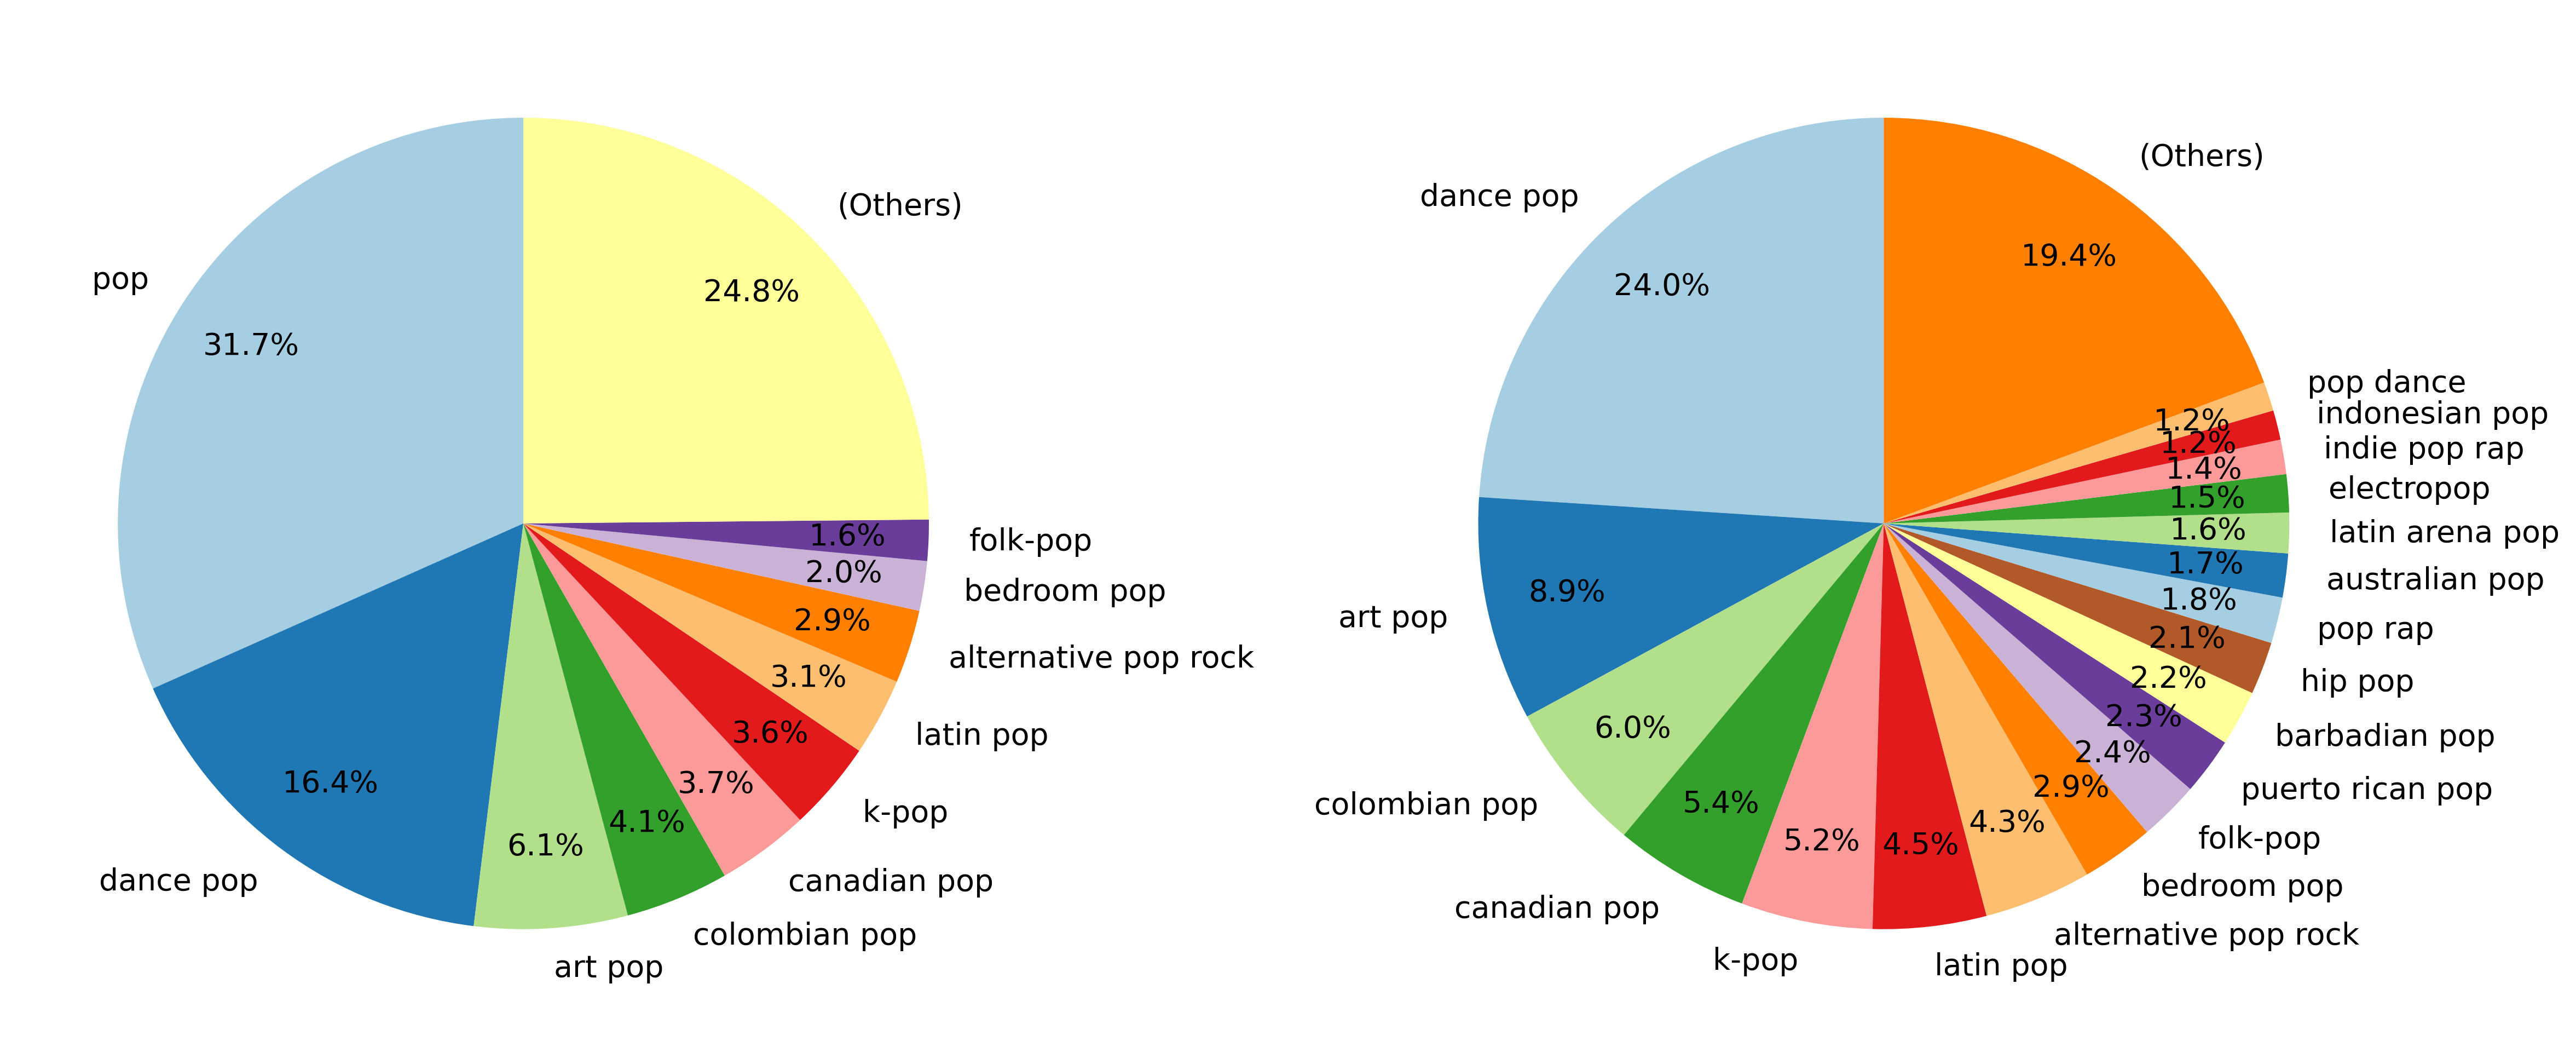

<Figure size 1980x1500 with 0 Axes>

In [172]:
pop_stream_df = stream_df.dropna()
# pop_stream_df = pop_stream_df[pop_stream_df['genres'].apply(lambda r: any('pop' in g for g in r))]
pop_stream_df = pop_stream_df[pop_stream_df['first_genre'].str.contains('pop')]

# display(pop_stream_df)

unique_pop_genres = list(pop_stream_df['first_genre'].unique())

df = pop_stream_df.pivot_table(index='first_genre', values='Streams', aggfunc='sum')
df.sort_values('Streams', ascending=False, inplace=True)

tdf = df.iloc[10:].sum().to_frame().T
tdf.index = ['(Others)']
df1 = pd.concat([df.iloc[:10], tdf], ignore_index=False)

tdf = df.iloc[20:].sum().to_frame().T
tdf.index = ['(Others)']
df2 = pd.concat([df.iloc[1:20], tdf], ignore_index=False)

# display(df1, df2)
# print(df.sum(), df1.sum(), df2.sum() + df.iloc[0])

fig, ax  = plt.subplots(ncols=2, figsize=(8, 4))

textprops = {'size': 'smaller', 'color': 'black'}

ax[0].pie(df1['Streams'], labels=df1.index, startangle=90, colors=plt.cm.Paired.colors, autopct='%1.1f%%', pctdistance=0.8, textprops=textprops)
ax[1].pie(df2['Streams'], labels=df2.index, startangle=90, colors=plt.cm.Paired.colors, autopct='%1.1f%%', pctdistance=0.8, textprops=textprops)

plt.tight_layout()
plt.show()

plt.savefig(f'{DIR_FG}/pop_sub_shares.svg', format='svg')

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness
count,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000
mean,0.271448,0.616162,0.636660,0.076734,0.172611,-6.960715,0.076763
std,0.253408,0.146769,0.182739,0.195004,0.102813,2.796547,0.058385
min,0.000016,0.078300,0.100445,0.000000,0.037300,-21.355500,0.024600
25%,0.059700,0.522925,0.513472,0.000005,0.105400,-8.162000,0.040423
50%,0.199559,0.616745,0.655250,0.001125,0.145833,-6.335111,0.055777
75%,0.432077,0.717792,0.771000,0.030543,0.205167,-5.015437,0.093500
max,0.959000,0.966000,0.995000,0.957000,0.891000,-1.925000,0.419000


,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness
count,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000,582.000000
mean,0.271448,0.616162,0.636660,0.076734,0.172611,-6.960715,0.076763
std,0.253408,0.146769,0.182739,0.195004,0.102813,2.796547,0.058385
min,0.000016,0.078300,0.100445,0.000000,0.037300,-21.355500,0.024600
25%,0.059700,0.522925,0.513472,0.000005,0.105400,-8.162000,0.040423
50%,0.199559,0.616745,0.655250,0.001125,0.145833,-6.335111,0.055777
75%,0.432077,0.717792,0.771000,0.030543,0.205167,-5.015437,0.093500
max,0.959000,0.966000,0.995000,0.957000,0.891000,-1.925000,0.419000


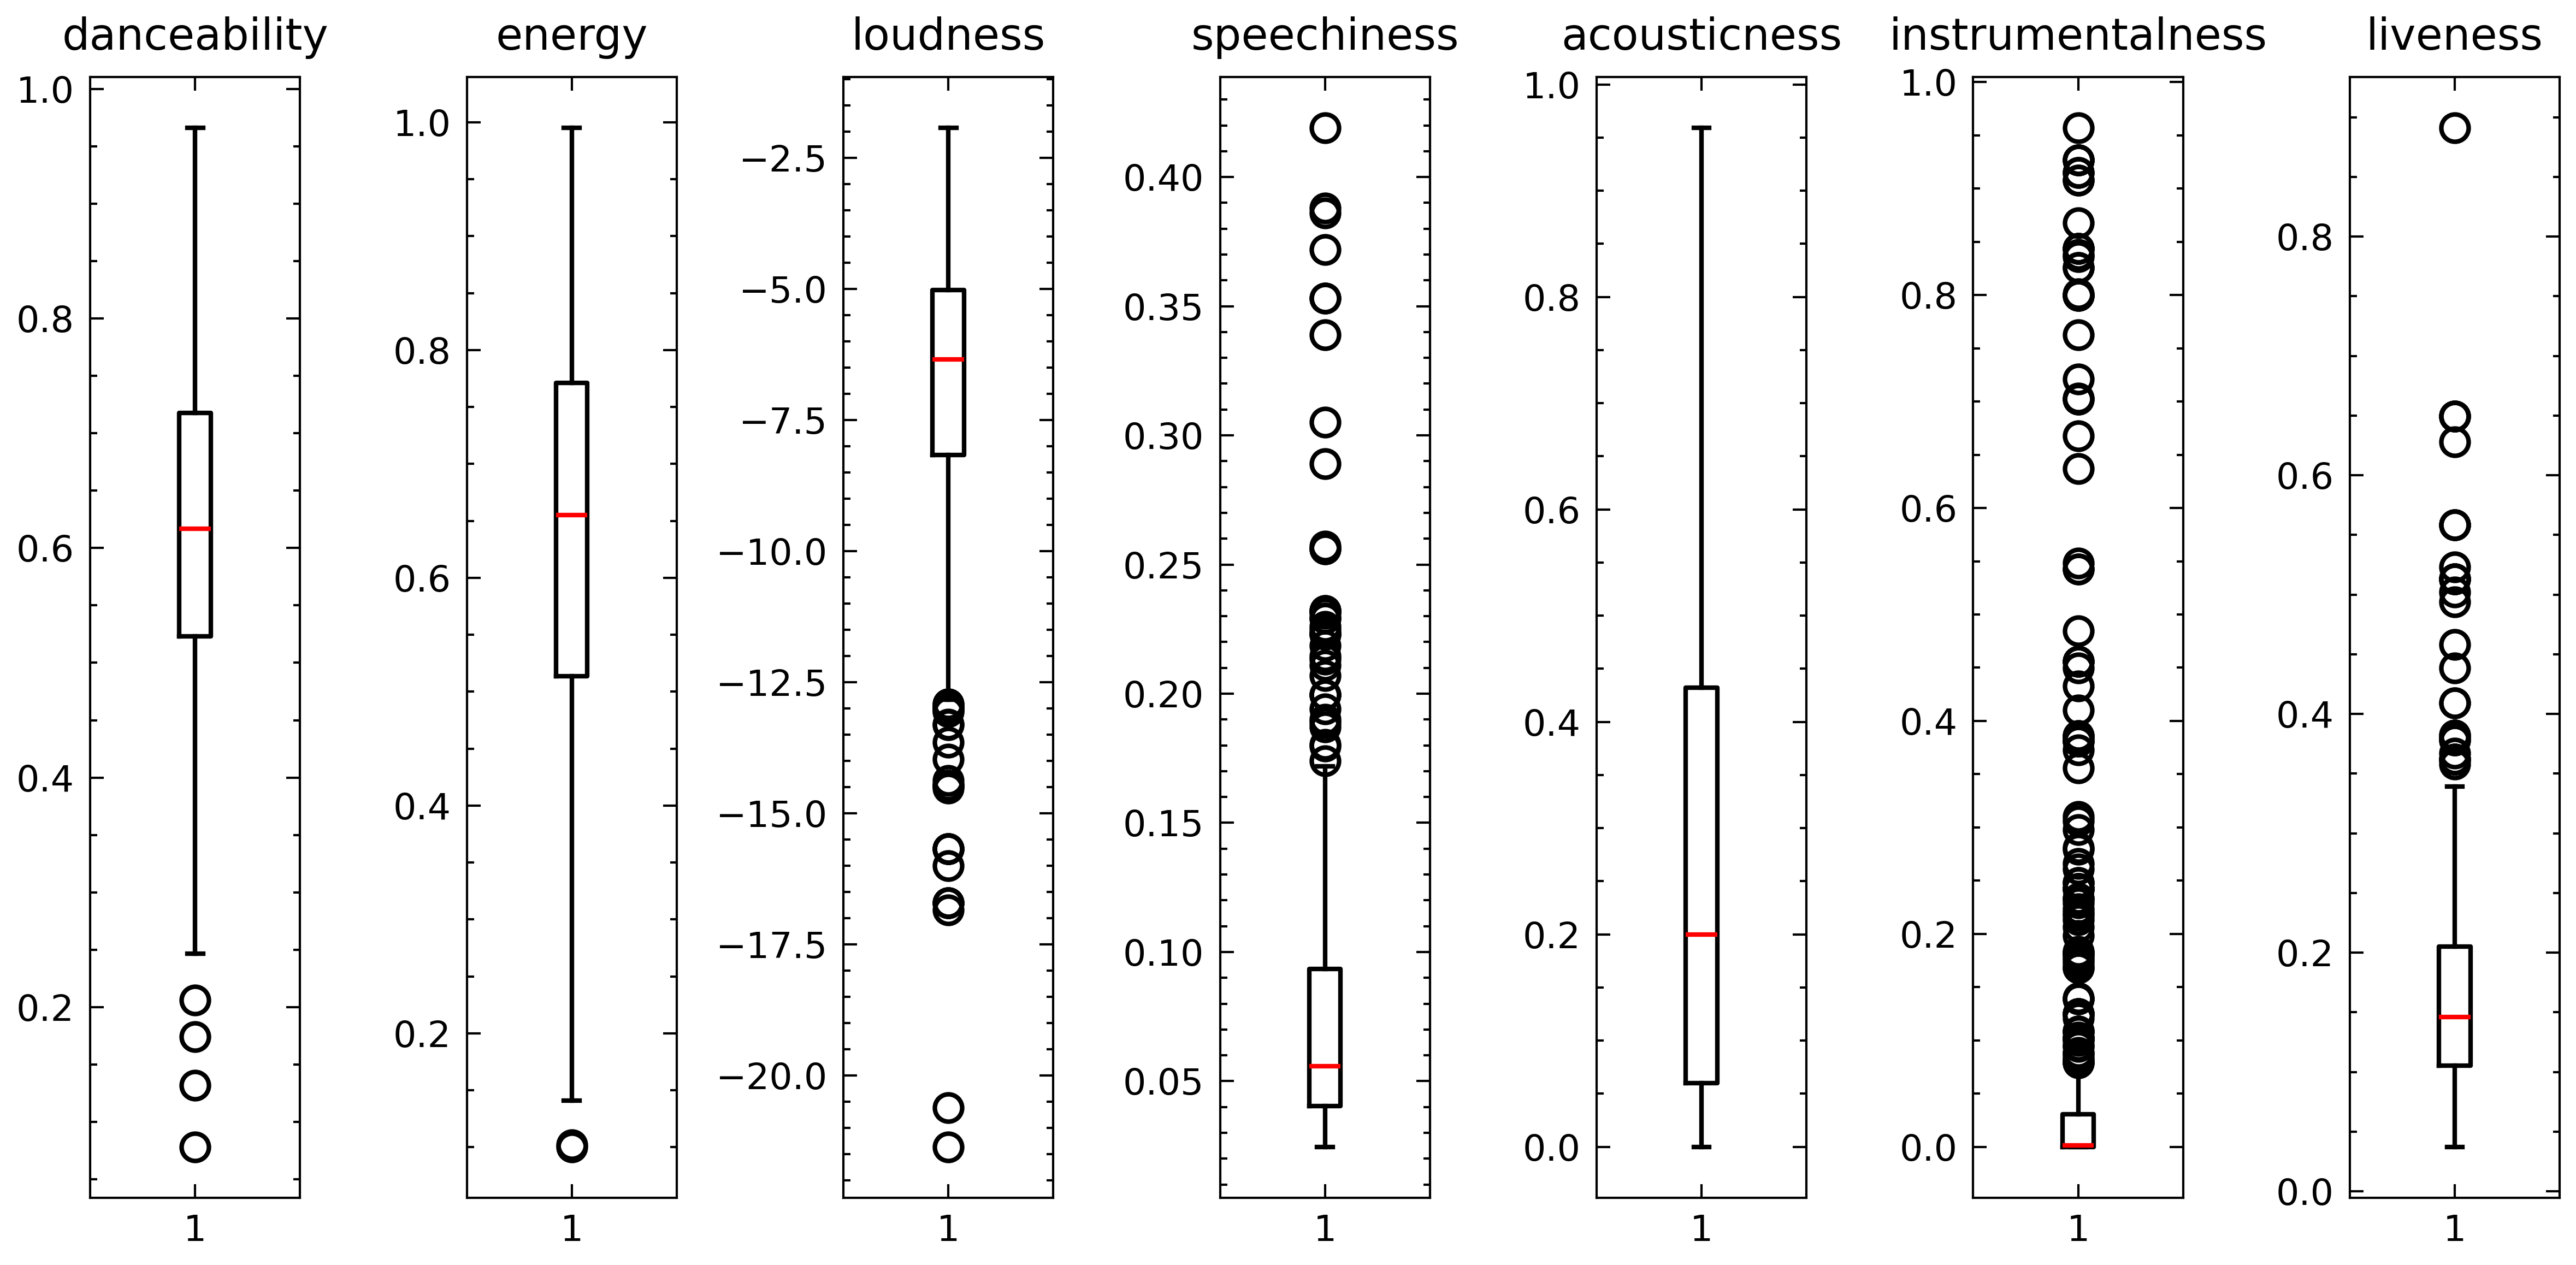

In [175]:
vproperties = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']
# vproperties = ['danceability',  'speechiness', 'liveness']

df = genres_df.pivot_table(index='genres', values=vproperties, aggfunc='mean')

display(df.describe())
display(df.describe())

# fig, ax = plt.subplots(ncols=len(vproperties), figsize=(8, 4))
fig, ax = plt.subplots(ncols=len(vproperties), figsize=(8, 4))

for idx, p in enumerate(vproperties):
    ax[idx].boxplot(df[p])
    ax[idx].set_title(p)

# for idx, p in enumerate(vproperties[:3]):
#   ax[0, idx].boxplot(df[p])
#   ax[0, idx].set_title(p)
#
# for idx, p in enumerate(vproperties[3:]):
#   ax[1, idx].boxplot(df[p])
#   ax[1, idx].set_title(p)

plt.tight_layout()
plt.show()